### Homework for the Module 2 of the ML Bootcamp
#### Linear Regression

For reference of Commands of this course: 
   https://github.com/alexeygrigorev/mlbookcamp-code/blob/master/chapter-02-car-price/02-carprice.ipynb

__Dataset__

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

__Data Preparation: Standardizing the data__

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv')
len(df)

9704

In [3]:
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


The goal of this homework is to create a regression model for predicting the car fuel efficiency (column 'fuel_efficiency_mpg')

In [4]:
df.dtypes

engine_displacement      int64
num_cylinders          float64
horsepower             float64
vehicle_weight         float64
acceleration           float64
model_year               int64
origin                  object
fuel_type               object
drivetrain              object
num_doors              float64
fuel_efficiency_mpg    float64
dtype: object

In [5]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

string_columns = list(df.dtypes[df.dtypes == 'object'].index)

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

In [6]:
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,europe,gasoline,all-wheel_drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,usa,gasoline,front-wheel_drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,europe,gasoline,front-wheel_drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,usa,diesel,all-wheel_drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,europe,gasoline,all-wheel_drive,2.0,12.488369


__Exploratory Data Analysis:__

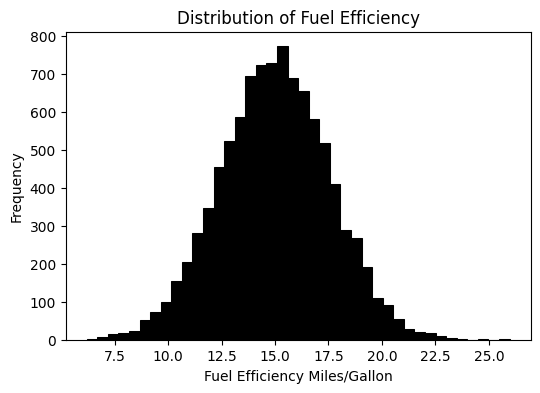

In [7]:
plt.figure(figsize=(6, 4))

sns.histplot(df.fuel_efficiency_mpg, bins=40, color='black', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Fuel Efficiency Miles/Gallon')
plt.title('Distribution of Fuel Efficiency')

plt.show()

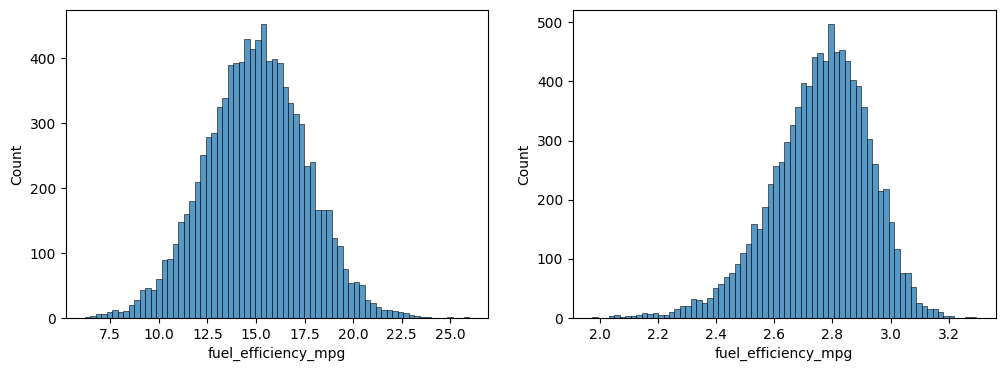

In [8]:
# Log transform target to check for long tail distribution
fig, ax = plt.subplots(1,2, figsize=(12, 4))
sns.histplot(df.fuel_efficiency_mpg, bins = 70, ax=ax[0])
sns.histplot(np.log1p(df.fuel_efficiency_mpg), bins = 70, ax=ax[1]) # log scale
plt.show()

In [9]:
# Orginal Data Frame
original_df = df.copy()

In [10]:
base = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year', 'fuel_efficiency_mpg']

# Using only the base columns in our data frame
df = df[base]

__Question 1__ \
There's one column with missing values. What is it?

In [11]:
df.isnull().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

__Question 2__ \
What's the median (50% percentile) for variable 'horsepower'?

In [12]:
df['horsepower'].median()

np.float64(149.0)

__Validation Framework:__ 
- Prepare and split the dataset 
- Shuffle the dataset (the filtered one you created above), use seed 42.
- Split your data in train/val/test sets, with 60%/20%/20% distribution.

In [13]:
# Shuffle data with the rundom seed
def shuffle_dataset(random_seed, data):
    n = len(data)
    np.random.seed(random_seed)
    idx = np.arange(n)
    np.random.shuffle(idx)
    
    data_shuffled = data.iloc[idx].reset_index(drop=True)
    return data_shuffled

df = shuffle_dataset(42, df)

In [14]:
df.head(2)

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,220,144.0,2535.887591,2009,16.642943
1,160,141.0,2741.170484,2019,16.298377


In [15]:
# Split data with the ratio 60/20/20
def split_data(data, n_val_perc, n_test_perc):
    n = len(data)
    n_val = int(n * n_val_perc)
    n_test = int(n * n_test_perc)
    n_train = n - n_val - n_test
    
    df_train = data.iloc[:n_train]
    df_val = data.iloc[n_train:n_train + n_val]
    df_test = data.iloc[n_train + n_val:]
    
    return df_train, df_val, df_test

df_train, df_val, df_test = split_data(df, 0.2, 0.2)

In [16]:
# Exclude target from train set
def remove_target_from_train(df_train, df_val, df_test, target_name):
    # y_train = df_train[target_name]
    # y_val = df_val[target_name]
    # y_test = df_test[target_name]

    y_train = df_train[target_name].values
    y_val = df_val[target_name].values
    y_test = df_test[target_name].values

    # Covert our target variable to log for better execution of the model
    y_train = np.log1p(y_train)
    y_val = np.log1p(y_val)
    y_test = np.log1p(y_test)

    # Once we have fetched the target vector, we dont want that as our feature in the training data 
    del df_train[target_name]
    del df_val[target_name]
    del df_test[target_name]
    
    return df_train, df_val, df_test, y_train, y_val, y_test

df_train, df_val, df_test, y_train, y_val, y_test = remove_target_from_train(df_train, df_val, df_test, 'fuel_efficiency_mpg')

__Question 3__
- We need to deal with missing values for the column from Q1.
- We have two options: fill it with 0 or with the mean of this variable.
- Try both options. For each, train a linear regression model without regularization using the code from the lessons.
- For computing the mean, use the training only!
- Use the validation dataset to evaluate the models and compare the RMSE of each option.
- Round the RMSE scores to 2 decimal digits using round(score, 2)
- Which option gives better RMSE?

__Linear Regression Model:__

In [17]:
def train_linear_regression(X, y):
    # transform input data from pandas DataFrame to numpy arrays
    #X, y = np.array(X), np.array(y)
    
    ones = np.ones(X.shape[0])
    # append vector with all ones in the beginning of training matrix
    X = np.column_stack([ones, X])
    
    # train Linear Regression
    # 1. Calculate Gram matrix
    XTX = X.T.dot(X)
    # 2. Take inverse of Gram matrix
    XTX_inv = np.linalg.inv(XTX)
    # 3. Calculate weights vector w
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

Preparing the Feature Matrix:

In [18]:
# Fill Missing values with 0
def prepare_X(df):
    #df_num = df[base]
    df_num = df.copy()
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

# Fill Missing values with mean of the variable missing i.e. having null values (here horsepower)
def prepare_X_Mean(df, null_variable):
    #df_num = df[base]
    df_num = df.copy()
    df_num[null_variable] = df_num[null_variable].fillna(df_num[null_variable].mean())
    X = df_num.values
    return X

Apply the Model:

In [19]:
def apply_the_model(X, w):
    # transform input data from pandas DataFrame to numpy array
    #X = np.array(X)
    #ones = np.ones(X.shape[0])
    #X = np.column_stack([ones, X])
    
    # make predictions
    y_pred_weighted = X.dot(w)
    return y_pred_weighted

Root Mean Squared Error Calculate:

In [20]:
def rmse(y_pred, y_true):
    assert(len(y_pred) == len(y_true))
    error = y_pred - y_true
    se = error ** 2
    mse = np.mean(se)
    rmse = np.sqrt(mse)
    return rmse

Question 3 Solution for 2 options: Training the data by filling null with 0 & Training the data by filling the mean value --->

In [21]:
# Option 1: Filling the missing value with 0
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)
y_pred = w_0 + apply_the_model(df_val, w)
print('Option 1: Filling the missing value with 0')
#print('Predicted Value', y_pred)
print('RMSE (Original)', rmse(y_pred, y_val))
#print('RMSE (rounded by two places)', rmse(y_pred, y_val).round())
print('RMSE (rounded by two places)', round(rmse(y_pred, y_val), 2))

# Option 2: Filling the missing value with the mean of the horsepower feature
X_train = prepare_X_Mean(df_train, 'horsepower')
w_0, w = train_linear_regression(X_train, y_train)
y_pred = w_0 + apply_the_model(df_val, w)
print('Option 2: Filling the missing value with Mean of', 'horsepower')
print('RMSE (Original)', rmse(y_pred, y_val))
print('RMSE (rounded by two places)', round(rmse(y_pred, y_val), 2))

Option 1: Filling the missing value with 0
RMSE (Original) 0.03915910132510417
RMSE (rounded by two places) 0.04
Option 2: Filling the missing value with Mean of horsepower
RMSE (Original) 0.036903826459618976
RMSE (rounded by two places) 0.04


__Question 4__
- Now let's train a regularized linear regression.
- For this question, fill the NAs with 0.
- Try different values of r from this list: [0, 0.01, 0.1, 1, 5, 10, 100].
- Use RMSE to evaluate the model on the validation dataset.
- Round the RMSE scores to 2 decimal digits.
- Which r gives the best RMSE?
- If multiple options give the same best RMSE, select the smallest r.

__Regularization:__ \
Train Ridge Regression (L1-regularisation)

In [22]:
def train_linear_regression_reg(X, y, r):
    # transform input data from pandas DataFrame to numpy arrays
    #X, y = np.array(X), np.array(y)
    ones = np.ones(X.shape[0])
    # append vector with all ones in the beginning of training matrix
    X = np.column_stack([ones, X])
    
    # train Linear Regression
    # 1. Calculate Gram matrix
    XTX = X.T.dot(X)
    # 2. Introduce regularization (Adding hyperparameter multiplied by indentity matrix of XTX dimensions to XTX (Gram Matrix)
    XTX = XTX + r * np.eye(XTX.shape[0])
    # 3. Take inverse of Gram matrix
    XTX_inv = np.linalg.inv(XTX)
    # 4. Calculate weights vector w
    w = XTX_inv.dot(X.T).dot(y)
    #return w
    return w[0], w[1:]

In [23]:
X_train = prepare_X(df_train)

In [24]:
# Model Tunig
for r in [0, 0.0001, 0.001, 0.01, .1, 1, 5, 10, 100]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r)
    # Prediction of the validation dataset -> skipping apply_the_model() since its the same as below command
    y_pred = w_0 + df_val.dot(w)
    # print(r, rmse(y_pred, y_val))
    print(r, round(rmse(y_pred, y_val), 2))

0 0.04
0.0001 0.04
0.001 0.04
0.01 0.04
0.1 0.04
1 0.04
5 0.04
10 0.04
100 0.04


__Question 5__
- We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
- Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
- For each seed, do the train/validation/test split with 60%/20%/20% distribution.
- Fill the missing values with 0 and train a model without regularization.
- For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
- What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
- Round the result to 3 decimal digits (round(std, 3))

In [25]:
std_dev_list =[]

def linear_regression_diff_seed():
    for r in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 42]:
        # Because the orders were interchanged because of earlier commands, we are taking a copy of the original data frame 
        # & we can compare the RMSE of seed 42 that we calculated earlier matches with our current calculation
        #Data Preparation
        df = original_df.copy()
        df = df[base]
        df = shuffle_dataset(r, df)
        # print(df.head(1).values.round(2))
        #Validation Framework
        df_train, df_val, df_test = split_data(df, 0.2, 0.2)
        df_train, df_val, df_test, y_train, y_val, y_test = remove_target_from_train(df_train, df_val, df_test, 'fuel_efficiency_mpg')
        #Linear Regression
        X_train = prepare_X(df_train)
        w_0, w = train_linear_regression(X_train, y_train)
        y_pred = w_0 + df_val.dot(w)
        print(r, rmse(y_pred, y_val))
        # Ignoring 10 and 42 for calculation of Standard Deviation as asked in the question
        if (r != 10 and r!=42) : std_dev_list.append(rmse(y_pred, y_val))
        
    return std_dev_list

print('Spliting Dataset for the following seeds and their corresponding RMSE')
std_dev_list = linear_regression_diff_seed()

std_dev = np.std(np.array(std_dev_list))
print('Standard deviation of the RMSE with seed from 0 to 9 is', std_dev)
print('Standard deviation of the RMSE with seed from 0 to 9 (Rounded) is', round(std_dev, 3))

Spliting Dataset for the following seeds and their corresponding RMSE
0 0.03682659903079782
1 0.038316156624462853
2 0.03822343784506888
3 0.03740114862566441
4 0.03609331644938739
5 0.03766730216231432
6 0.0377247500817501
7 0.03750155489541993
8 0.0387607259092907
9 0.03765241878943869
10 0.0366956274760566
42 0.03915910132510417
Standard deviation of the RMSE with seed from 0 to 9 is 0.0007201634988835777
Standard deviation of the RMSE with seed from 0 to 9 (Rounded) is 0.001


> Note: Standard deviation shows how different the values are. If it's low, then all values are approximately the same. If it's high, the values are different. If standard deviation of scores is low, then our model is stable.

__Question 6__
- Split the dataset like previously, use seed 9.
- Combine train and validation datasets.
- Fill the missing values with 0 and train a model with r=0.001.
- What's the RMSE on the test dataset?

In [26]:
df = original_df.copy()
df = df[base]
df.head()

df = shuffle_dataset(9, df) # Seed = 9

df_train, df_val, df_test = split_data(df, 0.2, 0.2)
df_train, df_val, df_test, y_train, y_val, y_test = remove_target_from_train(df_train, df_val, df_test, 'fuel_efficiency_mpg')

# Combining datasets
# For final testing of the model we need to concatinate training and validation dataset &&& Also concat the Target Variable/Vector
df_full_train = pd.concat([df_train, df_val])  # Pandas concat dataframe
y_full_train = np.concatenate([y_train, y_val]) # Numpy concat target vector

# Resetting index
df_full_train = df_full_train.reset_index(drop=True)

# Getting feature matrix X
X_full_train = prepare_X(df_full_train)

# Train the final model with Tuning
w_0, w = train_linear_regression_reg(X_full_train, y_full_train, 0.001)

# Applying model to test data
X_test = prepare_X(df_test)
y_pred = w_0 + X_test.dot(w)
 
score = rmse(y_test, y_pred)

print("RMSE on the test dataset: ", score)

RMSE on the test dataset:  0.039196136444546614


__Example of Using the model:__

In [27]:
rand_example = df_test.iloc[786].to_dict()
rand_example

{'engine_displacement': 230.0,
 'horsepower': 173.0,
 'vehicle_weight': 4127.579993441064,
 'model_year': 2006.0}

In [28]:
X_test = prepare_X(pd.DataFrame([rand_example]))[0]
y_pred = w_0 + X_test.dot(w)
predicted_fuel_efficiency_mpg = np.expm1(y_pred)
print('Predicted Fuel Efficency MPG', predicted_fuel_efficiency_mpg)
print('Actual Fuel Efficency MPG of that record from the test dataset', np.expm1(y_test[786]))

Predicted Fuel Efficency MPG 10.046836601802248
Actual Fuel Efficency MPG of that record from the test dataset 9.195477247174264
